In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline
from scipy import signal
from scipy.signal import find_peaks_cwt
import glob
import matplotlib.gridspec as gridspec
from scipy import ndimage

The following code to calibrate the camera is taken from the
Udacity Lecture notes


In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*8,3), np.float32)
objp[:,:2] = np.mgrid[0:8, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('calibration_wide/GO*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (8,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (8,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        #cv2.imshow('img', img)
        #cv2.waitKey(500)

#cv2.destroyAllWindows()


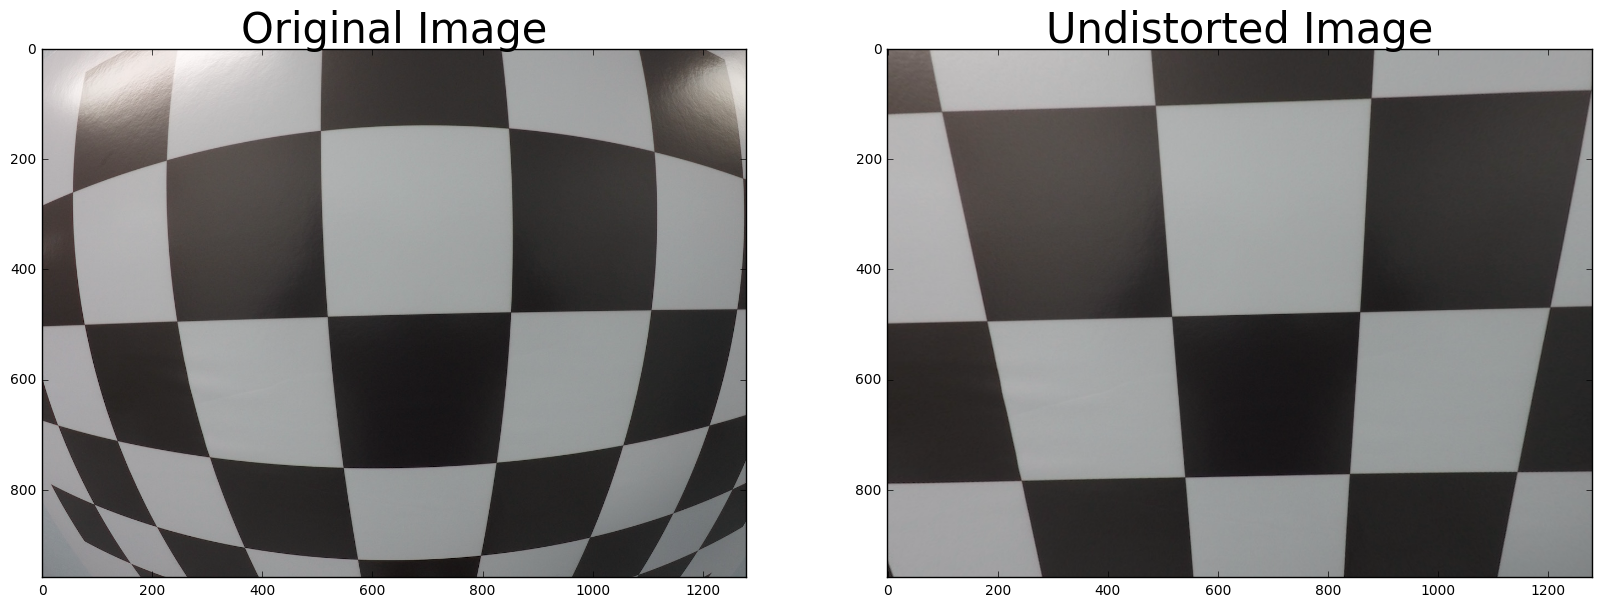

In [3]:
# Test undistortion on an image
img = cv2.imread('calibration_wide/test_image.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('calibration_wide/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration_wide/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [4]:
#Apply the distortion correction to the raw image.
#image = mpimg.imread('CarND-Advanced-Lane-Lines-master/test_images/solidYellowLeft.jpg')
image = cv2.imread('CarND-Advanced-Lane-Lines-master/test_images/test1.jpg')

image.shape

(720, 1280, 3)

In [5]:

def corners_unwarp(img, mtx, dist):
    # Pass in the image into this fumction
    #undistort using mtx and dist
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist
undist = corners_unwarp(image, mtx, dist)
undist_size = (undist.shape[1],undist.shape[0])
print(undist_size )

(1280, 720)


In [6]:
# From a genius December cohort, Wolfgang Stein

def show(*images,title=None):
    f, axes = plt.subplots(1,len(images), squeeze=False)
    f.set_size_inches((6 * len(images),8))
    if title and len(images)==1 and type(title) == str:
        title = [title]
    for i in range(len(images)):
        img = images[i]
        ax = axes[0][i]
        if title is not None:
            assert len(title) == len(images)
            t = title[i]
            ax.text(0.5, 1.05, t, transform=ax.transAxes, fontsize=14, verticalalignment='bottom', horizontalalignment='center')
        if len(img.shape) == 3:
            ax.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
        else:
            ax.imshow(img, cmap="gray")


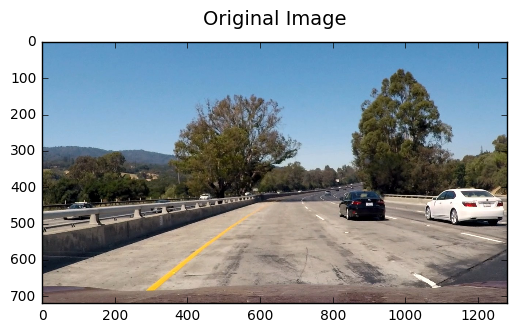

In [7]:
show(image,title="Original Image" )

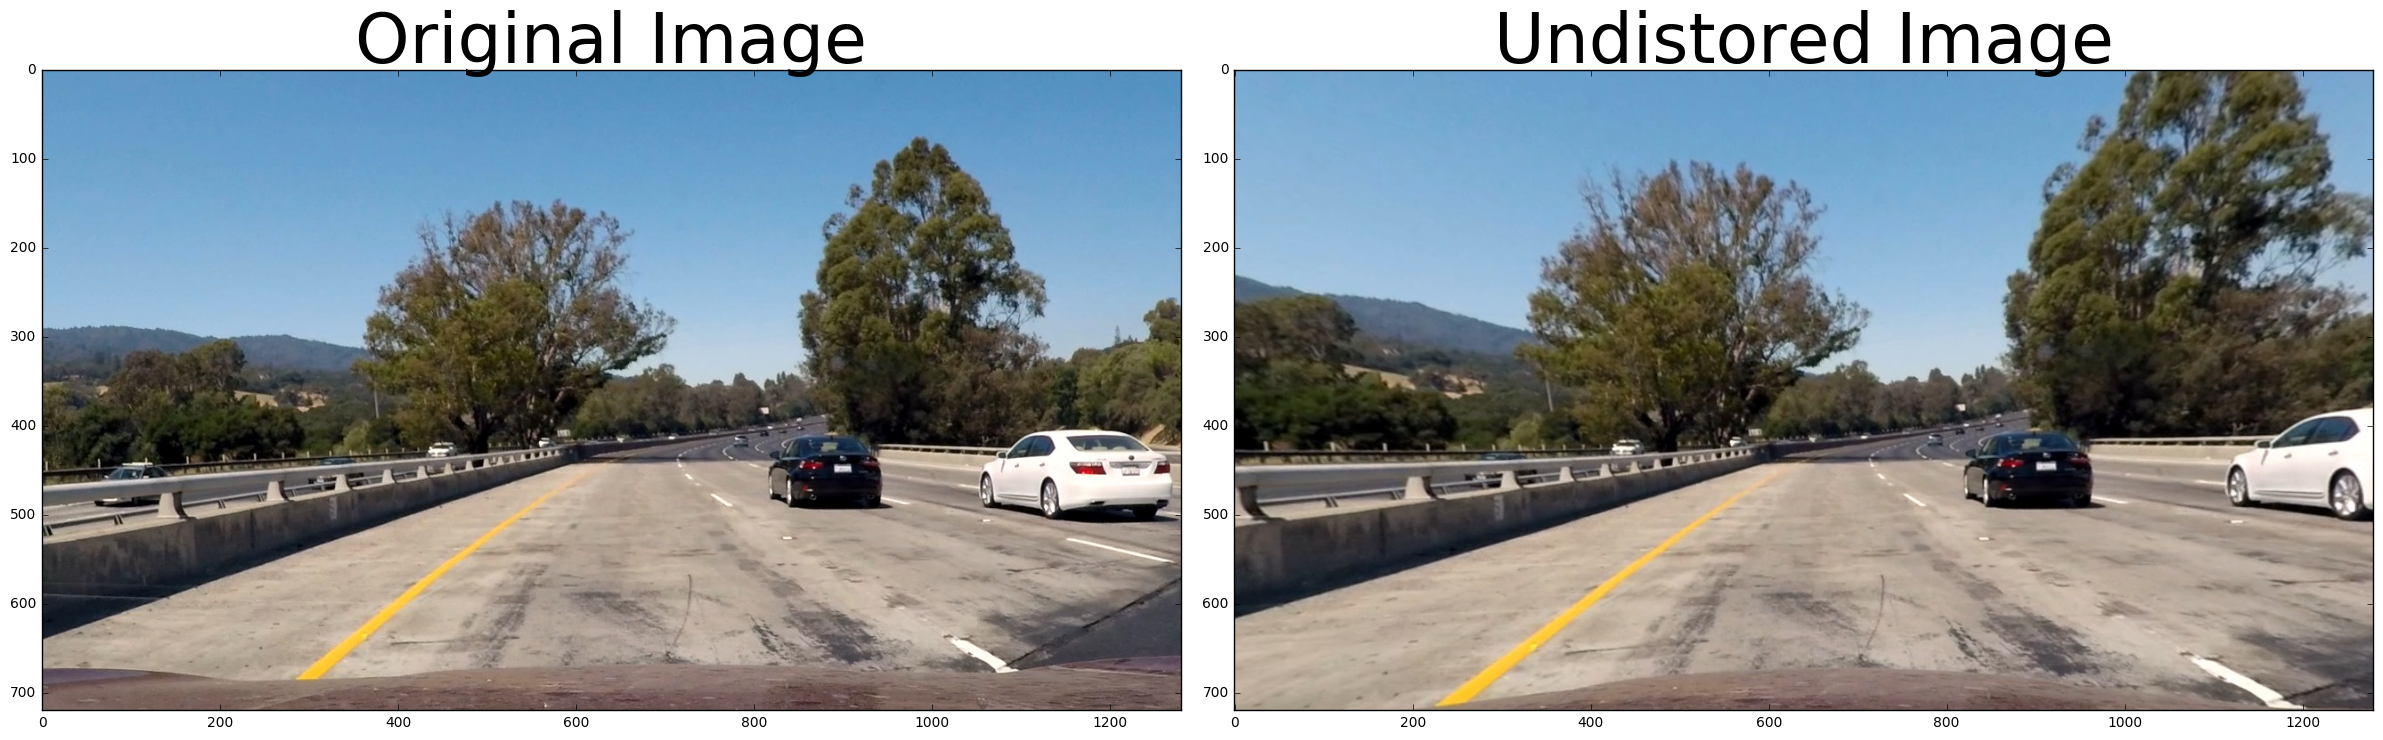

In [8]:

# plot the result
f, (ax1, ax2) = plt.subplots(1,2, figsize=(24,9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize = 50)
ax2.imshow(cv2.cvtColor(undist,cv2.COLOR_BGR2RGB))
ax2.set_title('Undistored Image', fontsize=50)



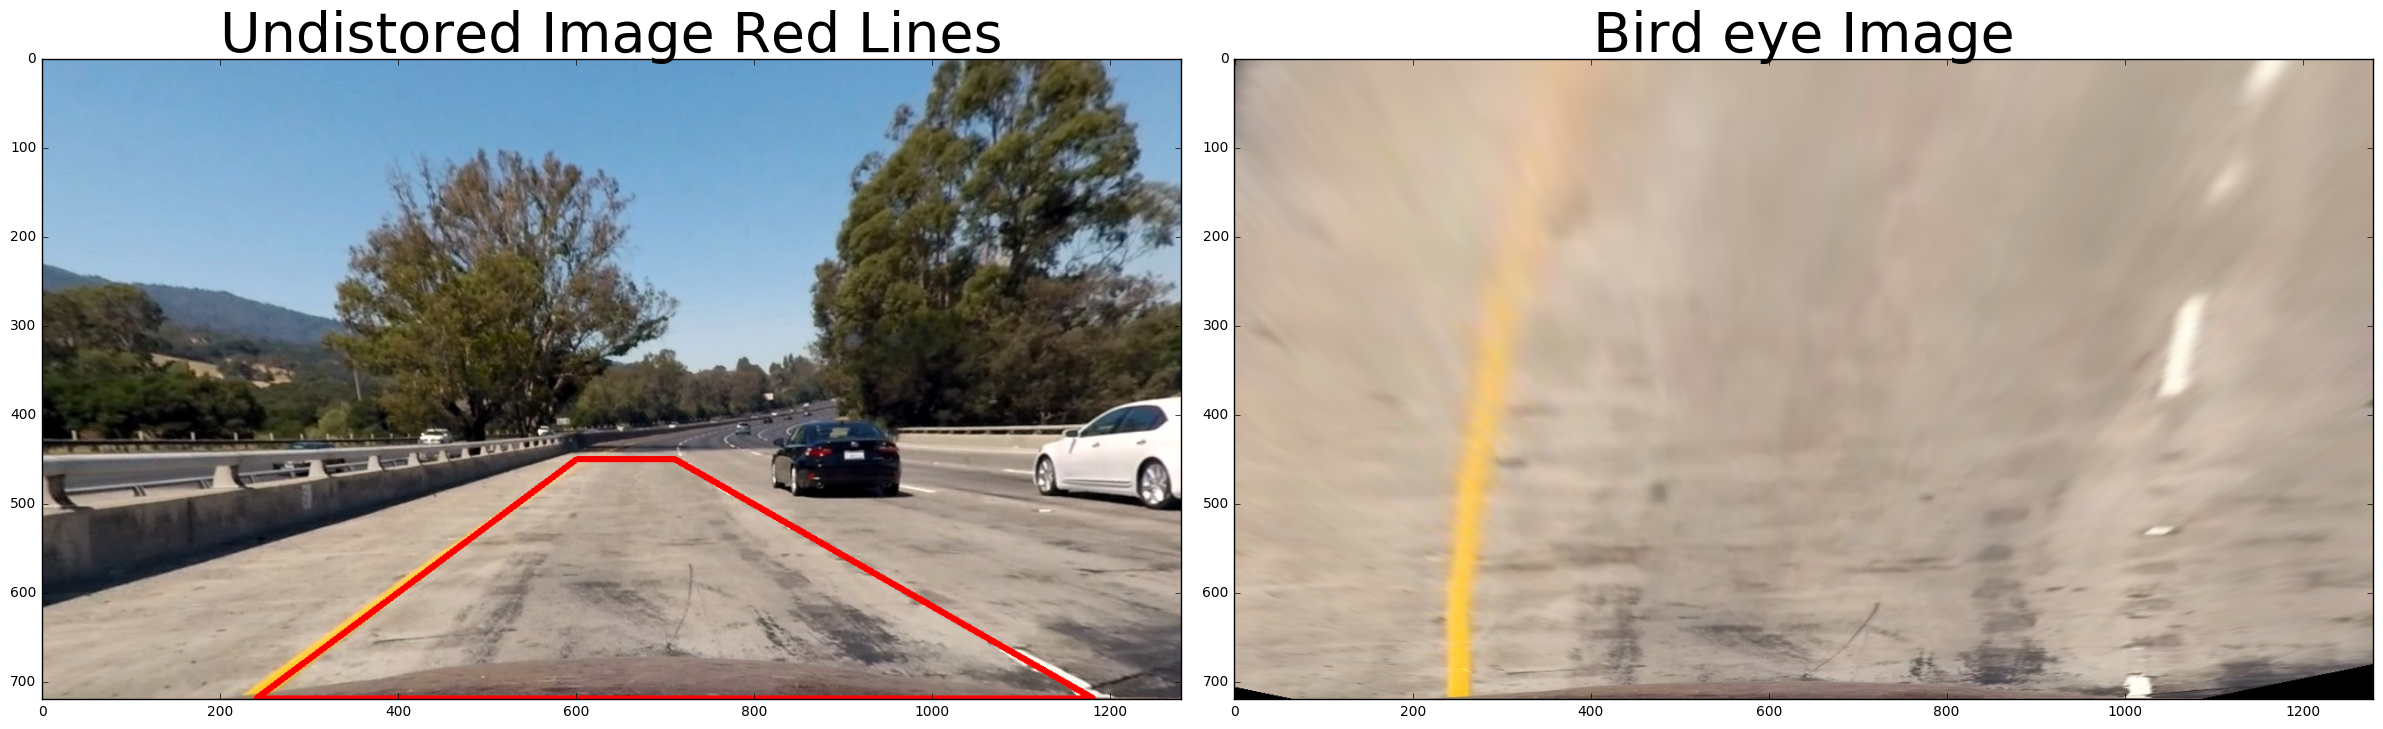

In [9]:
# define 4 source points for perspective transformation
src = np.float32([[220,719],[1220,719],[750,480],[550,480]])
# define 4 destination points for perspective transformation
dst = np.float32([[240,719],[1040,719],[1040,300],[240,300]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
# Warp an image using the perspective transform, M:
birdseye = cv2.warpPerspective(undist, M, (1280, 720), flags=cv2.INTER_LINEAR)
undist_redlines = np.copy(undist)
pts = np.array([[240,719],[600,450],[710,450],[1180,719]], np.int32)
pts = pts.reshape((-1,1,2))

undist_redlines =cv2.polylines(undist_redlines,[pts],True,(0,0,255),5)

# plot the result
f, (ax1, ax2) = plt.subplots(1,2, figsize=(24,9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(undist_redlines,cv2.COLOR_BGR2RGB))
ax1.set_title('Undistored Image Red Lines', fontsize = 40)
ax2.imshow(cv2.cvtColor(birdseye,cv2.COLOR_BGR2RGB))
ax2.set_title('Bird eye Image', fontsize=40)


In [10]:
def color_mask(img,min_thres,max_thres):
    return cv2.inRange(img, min_thres, max_thres) / 255

def binarize_img(img, min_thres, max_thres):
    return cv2.inRange(img, min_thres, max_thres) / 255

def apply_color_mask(hsv,img,low,high):
    mask = cv2.inRange(hsv, low, high)
    res = cv2.bitwise_and(img,img, mask= mask)
    return res

def moving_average(a, n=3):
    # Moving average
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def get_curvature(pol_a,y_pt):
    A = pol_a[0]
    B = pol_a[1]
    R_curve = (1+(2*A*y_pt+B)**2)**1.5/2/A
    return R_curve

def stack_arr(arr):
    return np.stack((arr, arr,arr), axis=2)

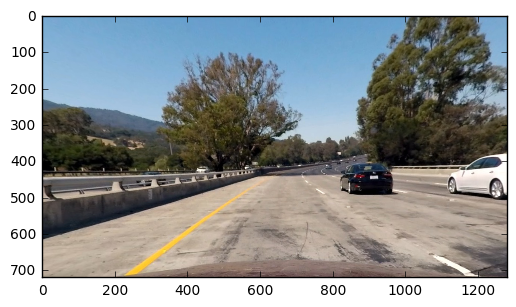

In [11]:
plt.imshow(cv2.cvtColor(undist,cv2.COLOR_BGR2RGB))

In [12]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # TAKE THE DERIVATIVE OF x or y 
    sobelx=cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    # take the absolute derivative or gradient
    abs_solvex = np.absolute(sobelx)
    # scale to 8-bit (0-255) then convert to type=uint8
    scaled_sobel = np.uint8(255*abs_solvex/np.max(abs_solvex))
    # create a mask of 1's where the scaled gradient magnitude
    # is > thres_min and < thres_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel>=thresh[0])&(scaled_sobel<=thresh[1])]=1
    # return this mask as the binary_output
    binary_output = sxbinary
    return binary_output

In [13]:
def mag_threshold(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply threshold
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # TAKE THE DERIVATIVE OF x or y 
    sobelx=cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely=cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate gradient magnitude
    abs_sobelxy = np.sqrt(sobelx**2 + sobely**2)
    # scale to 8-bit (0-255) then convert to type=uint8
    scale_factor = np.max(abs_sobelxy/255)
    scaled_sobel = (abs_sobelxy/scale_factor).astype(np.uint8)
    # create a mask of 1's where the scaled gradient magnitude
    # is > thres_min and < thres_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel>=mag_thresh[0])&(scaled_sobel<=mag_thresh[1])]=1
    # return this mask as the binary_output
    binary_output = sxbinary
    return binary_output


In [14]:
def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # TAKE THE DERIVATIVE OF x or y 
    sobelx=cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely=cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    #use np.arctan2() to calculate direction of gradient
    dir_sobel = np.arctan2(abs_sobely, abs_sobelx)    
    # create a mask of 1's where the scaled gradient magnitude
    # is > thres_min and < thres_max
    sxbinary = np.zeros_like(dir_sobel)
    sxbinary[(dir_sobel>=thresh[0])&(dir_sobel<=thresh[1])]=1
    # return this mask as the binary_output
    binary_output = sxbinary
    return binary_output

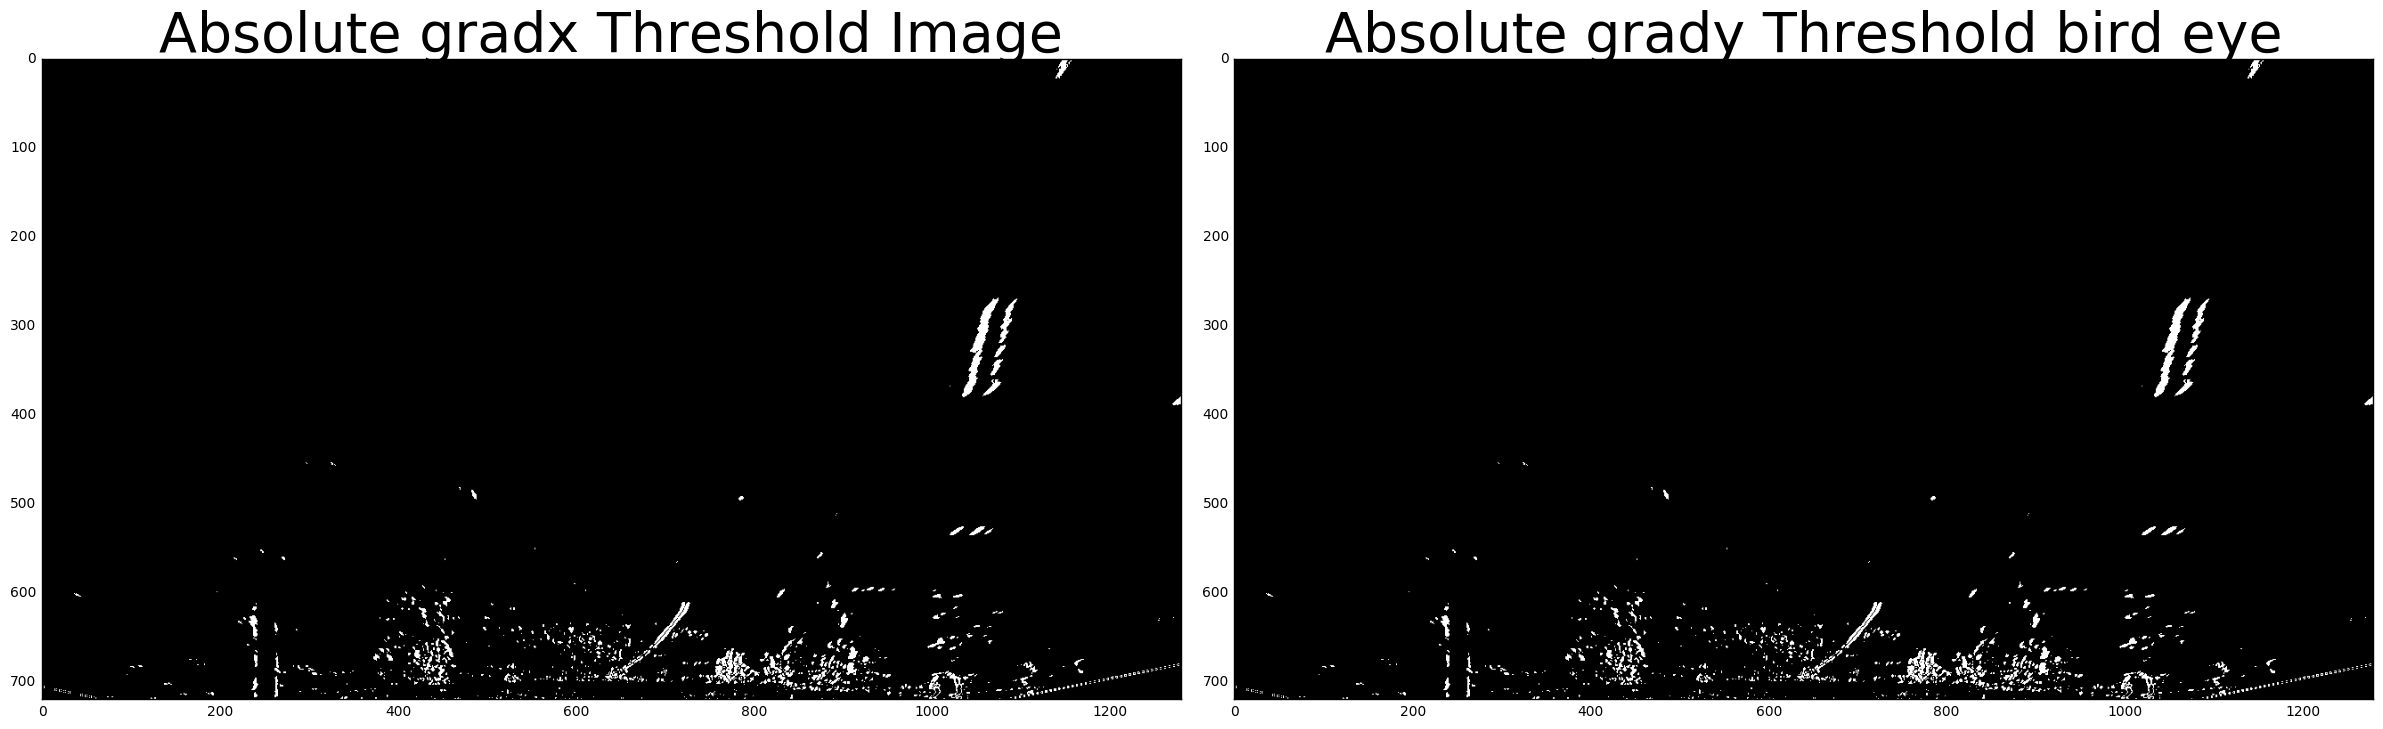

In [15]:
# Choose a Sobel kernel size
ksize = 5 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(birdseye, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(birdseye, orient='y', sobel_kernel=ksize, thresh=(20, 100))

# plot the result
f, (ax1, ax2) = plt.subplots(1,2, figsize=(24,9))
f.tight_layout()
ax1.imshow(gradx, cmap='gray')
ax1.set_title('Absolute gradx Threshold Image', fontsize = 40)
ax2.imshow(grady, cmap='gray')
ax2.set_title('Absolute grady Threshold bird eye', fontsize=40)


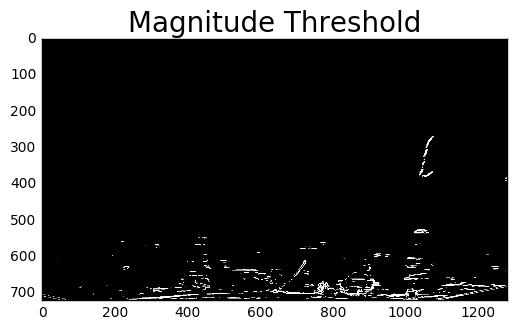

In [16]:
mag_binary = mag_threshold(birdseye, sobel_kernel=9, mag_thresh = (30, 100))

plt.imshow(mag_binary, cmap='gray')
plt.title('Magnitude Threshold', fontsize=20)

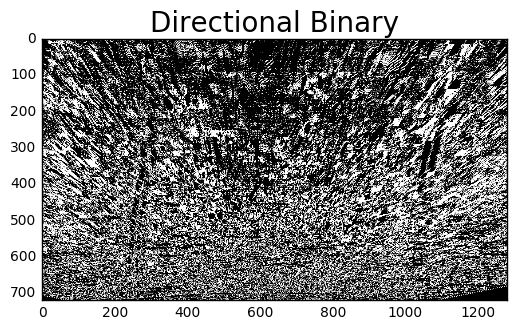

In [17]:
dir_binary = dir_threshold(birdseye, sobel_kernel= 15, thresh = (0.7, 1.3))
# plot the result
plt.imshow(dir_binary, cmap='gray')
plt.title('Directional Binary', fontsize=20)

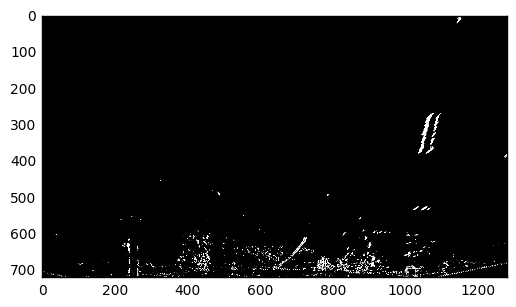

In [18]:
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
plt.imshow(combined, cmap='gray')

In [19]:
H = image[:,:,0]
S = image[:,:,1]
V = image[:,:,2]

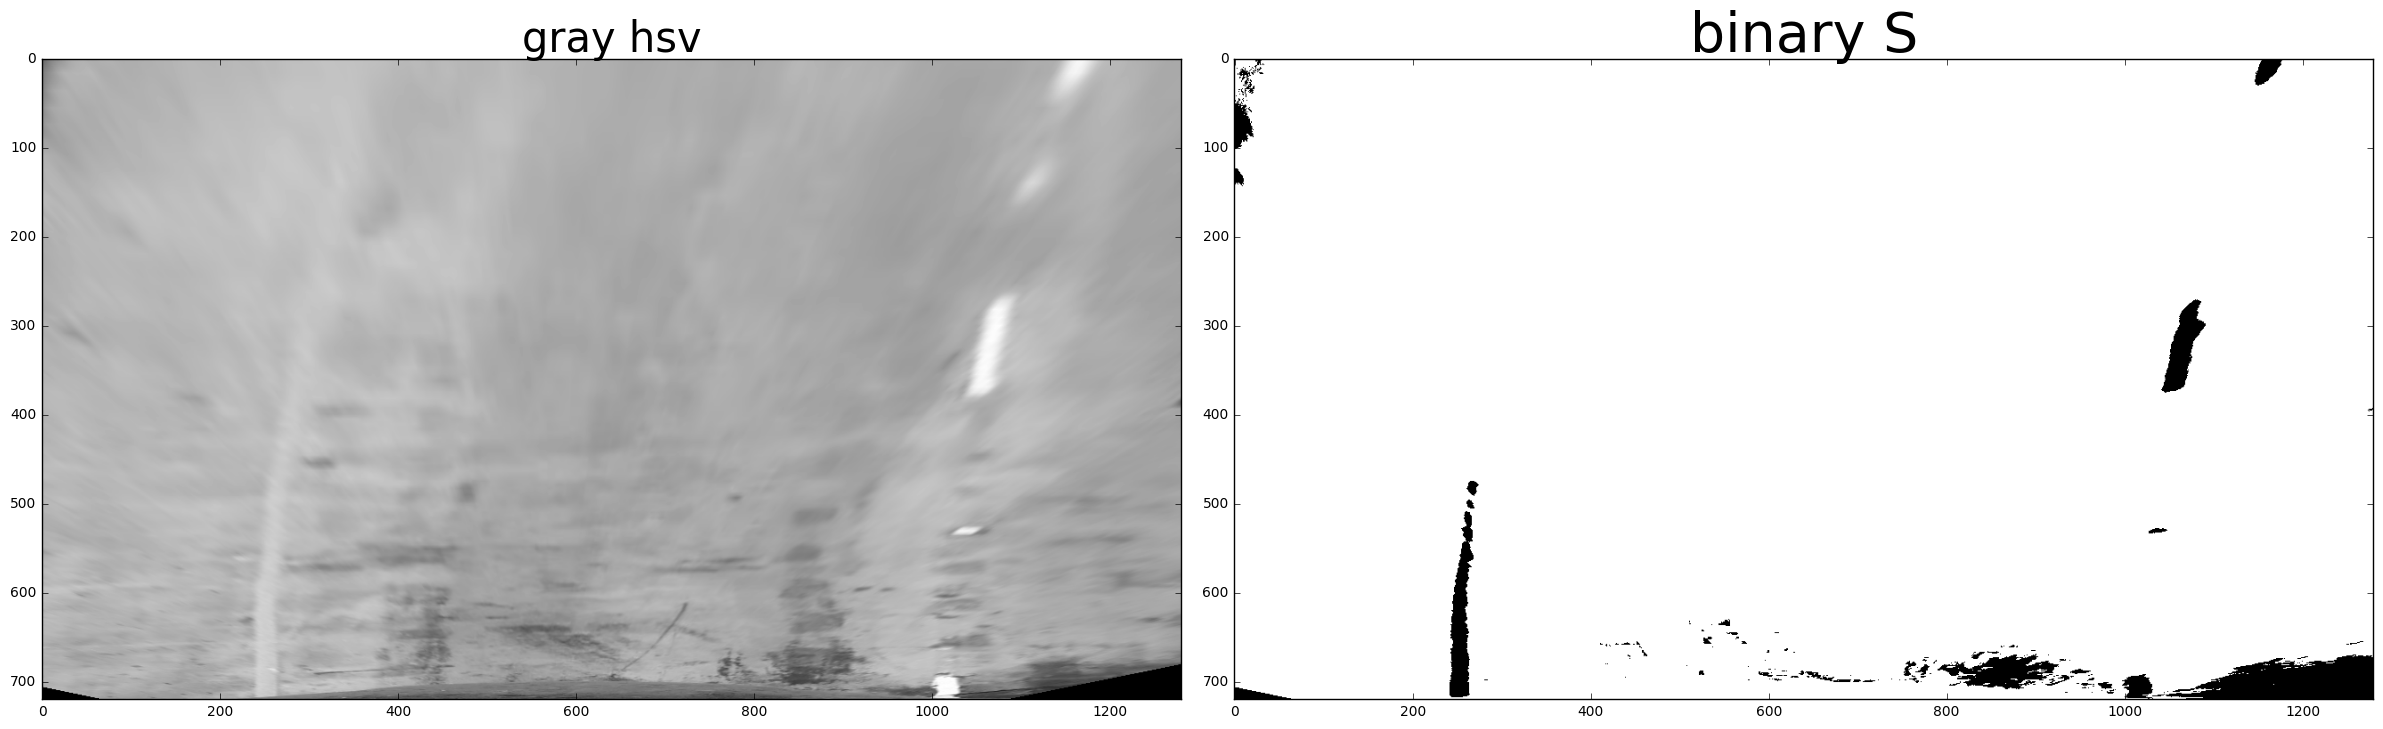

In [20]:
def hsv_select(img, thresh=(20, 80)):
    #convert to hsv color space
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    s_channel = hsv[:,:,1]
    binary = np.zeros_like(s_channel)
    binary[(s_channel > thresh[0])&(s_channel < thresh[1])]= 1
    return binary

hsv_binary = hsv_select(birdseye, thresh=(30,160))
S = birdseye[:,:,1]
# plot the result
f, (ax1, ax2) = plt.subplots(1,2, figsize=(24,9))
f.tight_layout()
ax1.imshow(S, cmap="gray")
ax1.set_title('gray hsv', fontsize = 30)
ax2.imshow(hsv_binary, cmap="gray")
ax2.set_title('binary S', fontsize=40)
   
    

In [21]:

#hsv_binary =np.transpose(np.nonzero(hsv_binary))


In [22]:
# Mask out all but yellow in the image
hsv_lower_yellow  = np.array([ 0, 80, 0], dtype = "uint8")
hsv_upper_yellow = np.array([ 30, 255, 255], dtype = "uint8")

sensitivity = 35
hsv_lower_white = np.array([0,0,255-sensitivity], dtype=np.uint8)
hsv_upper_white = np.array([255,sensitivity,255], dtype=np.uint8)

In [23]:
birdseye = cv2.GaussianBlur(birdseye,(5,5),0)

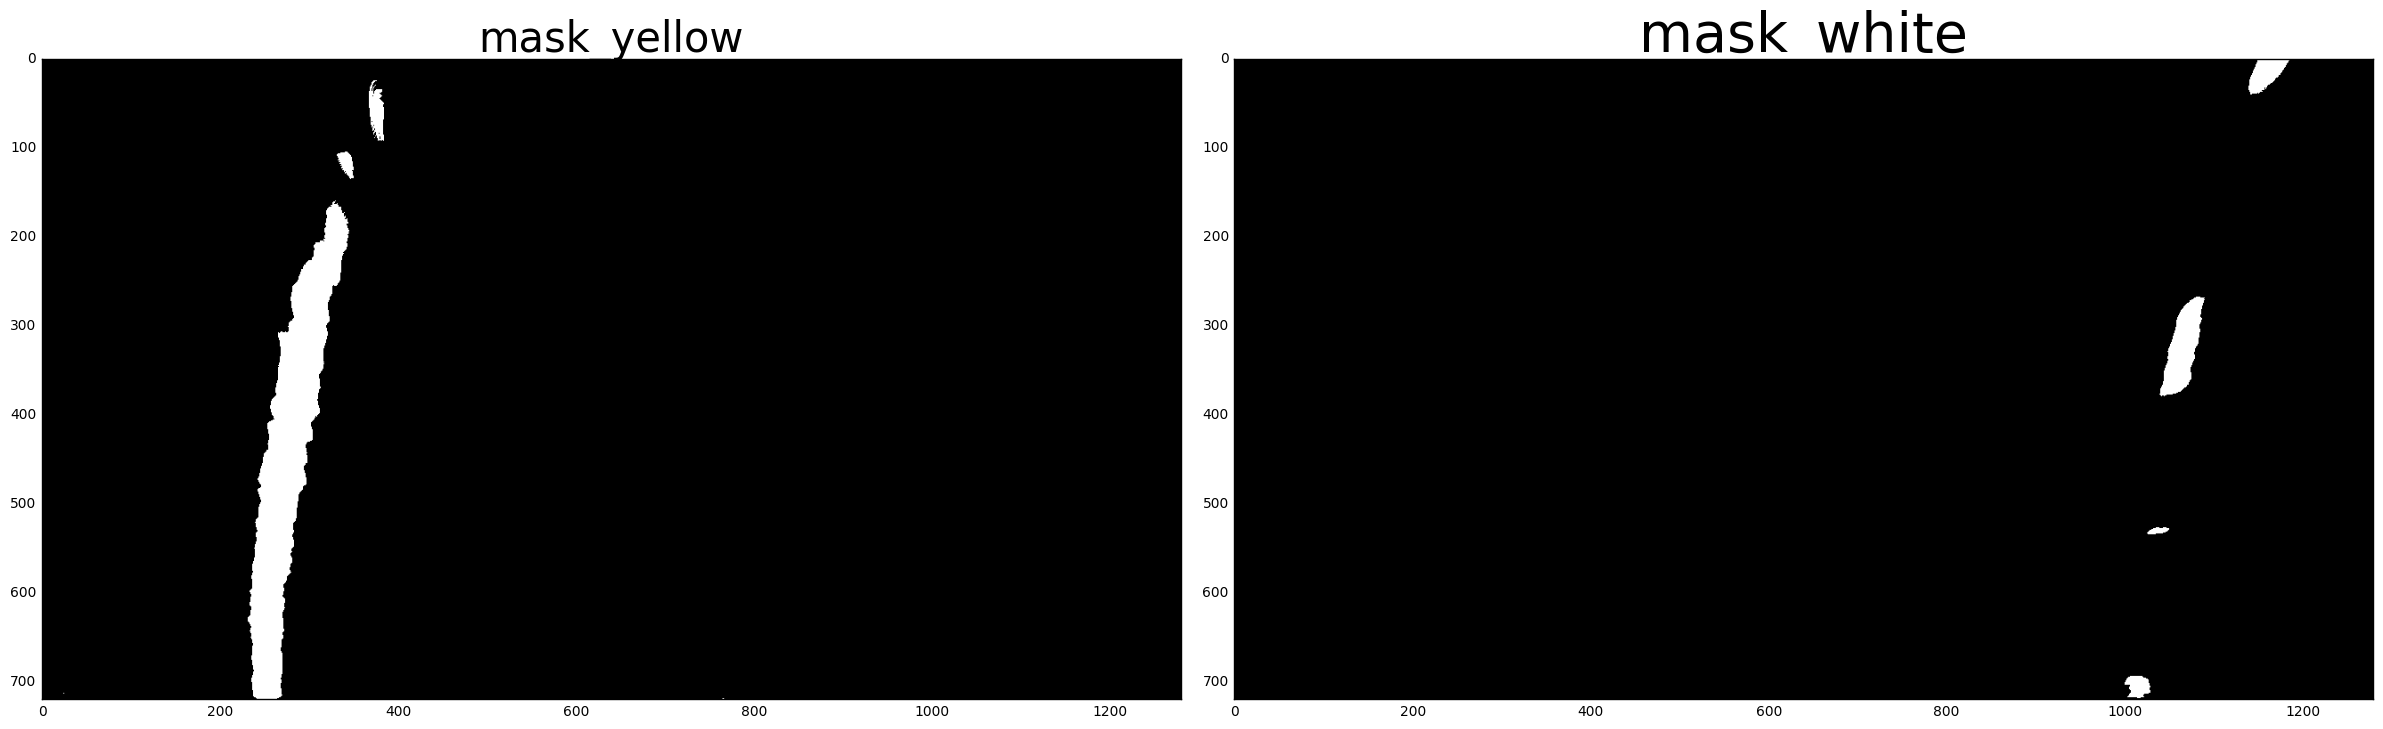

In [24]:
image_hsv_birdseye = cv2.cvtColor(birdseye,cv2.COLOR_BGR2HSV)

mask_yellow = color_mask(image_hsv_birdseye,hsv_lower_yellow ,hsv_upper_yellow )

mask_white = color_mask(image_hsv_birdseye,hsv_lower_white,hsv_upper_white)
mask_lane = cv2.bitwise_or(mask_yellow,mask_white)

# plot the result
#f, (ax1, ax2,ax3) = plt.subplots(1,2,3, figsize=(24,9))
f, (ax1, ax2) = plt.subplots(1,2, figsize=(24,9))

f.tight_layout()
ax1.imshow(mask_yellow, cmap="gray")
ax1.set_title('mask_yellow', fontsize = 30)
ax2.imshow(mask_white, cmap="gray")
ax2.set_title('mask_white', fontsize=40)


In [25]:
mask_lane.shape

(720, 1280)

In [26]:
#mask_lane = np.dtype(np.uint)

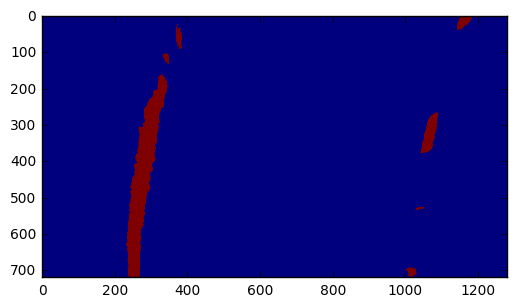

In [27]:
plt.imshow(mask_lane)

In [28]:
xy_yellow_pts = np.argwhere(mask_yellow>.8)
y_left = np.array(xy_yellow_pts[:,0])
x_left = np.array(xy_yellow_pts[:,1])
xy_white_pts = np.argwhere(mask_white>.8)
y_right = np.array(xy_white_pts[:,0])
x_right = np.array(xy_white_pts[:,1])
x_right

array([1150, 1151, 1152, ..., 1015, 1016, 1017])

/home/denise/anaconda3/envs/keras/lib/python3.5/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


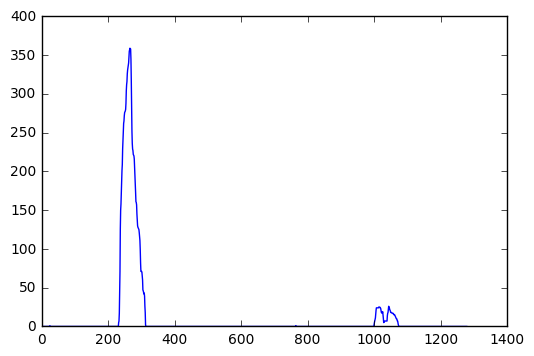

In [29]:
histogram = np.sum(mask_lane[mask_lane.shape[0]/2:,:],axis=0, )
plt.plot(histogram)

In [30]:
#peaks = find_peaks_cwt(histogram, np.arange(min_peak_width,max_peak_width))  
peaks = find_peaks_cwt(histogram, np.arange(80,250))  
print(peaks)

[265, 1034]


In [31]:
left_fit = np.polyfit(y_left, x_left, 2)
left_fitx = left_fit[0]*y_left**2 + left_fit[1]*y_left + left_fit[2]
right_fit = np.polyfit(y_right, x_right, 2)
right_fitx = right_fit[0]*y_right**2 + right_fit[1]*y_right + right_fit[2]

In [32]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval_left = np.max(y_left)
y_eval_right = np.max(y_right)

left_curverad = ((1 + (2*left_fit[0]*y_eval_left + left_fit[1])**2)**1.5) \
                             /np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval_right + right_fit[1])**2)**1.5) \
                                /np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1163.9    1213.7

1837.5046792 2010.06991529


In [33]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meteres per pixel in x dimension

left_fit_cr = np.polyfit(y_left *ym_per_pix, x_left*xm_per_pix, 2)
right_fit_cr = np.polyfit(y_right*ym_per_pix, x_right*xm_per_pix, 2)
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval_left + left_fit_cr[1])**2)**1.5) \
                             /np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval_right + right_fit_cr[1])**2)**1.5) \
                                /np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 3380.7 m    3189.3 m

2109.97426925 m 1979.63534943 m


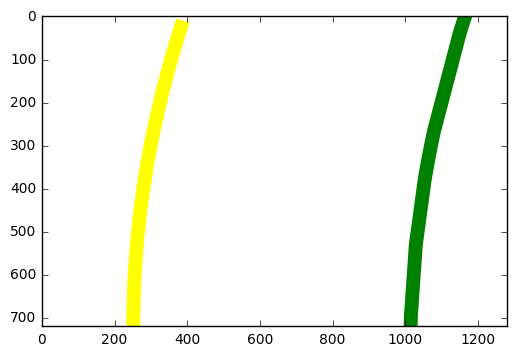

In [34]:
mark_size = 3
#plt.plot(x_left, y_left, 'o', color='red', markersize=mark_size)
#plt.plot(x_right, y_right, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, y_left, color='yellow', linewidth=10)
plt.plot(right_fitx, y_right, color='green', linewidth=10)
#plt.plot(left_fitx, y_left, color='yellow', linewidth=10)
#plt.plot(right_fitx, y_right, color='green', linewidth=10)
plt.gca().invert_yaxis() # to visualize as we do the images

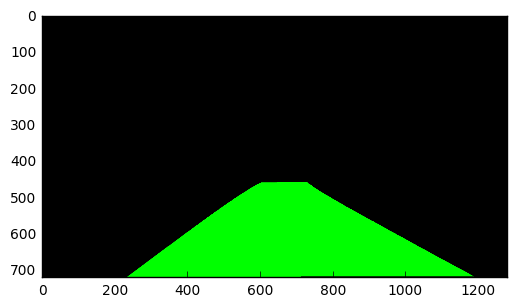

In [35]:
#draw the lines

# Create an image to draw the lines on
warp_zero = np.zeros_like(birdseye).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, y_left]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, y_right])))])
pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
cv2.fillPoly(warp_zero, np.int_([pts]), (0,255, 0))
    #poly=np.concatenate((leftline, rightline[::-1]), axis=0)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)

newwarp = cv2.warpPerspective(warp_zero, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    
font = cv2.FONT_HERSHEY_COMPLEX
cv2.putText(image, 'Estimated curvature: Left: {0}m, Right: {1}m.'.format(round(left_curverad, 2),
      
                                                                                   round(right_curverad, 2)),
                    (0, 160), font, 1, (255, 0, 0), 2)
    #cv2.putText(undistorted, 'Estimated distance right of center: {0}m'.format(round(off_center, 2)),
                    #(0, 80),
                    #font, 1, (255, 0, 0), 2)

        # Combine the result with the original image
plt.imshow(newwarp)

In [36]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [37]:
Minv = cv2.getPerspectiveTransform(dst, src)

In [38]:
#def draw_lane(self, original, left_x, left_y, right_x, right_y, curvature_left=None, curvature_right=None, off_center=None):


In [39]:
# meters from center
#xm_per_pix = 3.7/700 # meteres per pixel in x dimension
#screen_middel_pixel = img.shape[1]/2
#left_lane_pixel = lane_info[6][0]    # x position for left lane
#right_lane_pixel = lane_info[5][0]   # x position for right lane
#car_middle_pixel = int((right_lane_pixel + left_lane_pixel)/2)
#screen_off_center = screen_middel_pixel-car_middle_pixel
#meters_off_center = xm_per_pix * pixels_off_center

In [40]:
#left_fit_prev = np.array([0,0,0])
#right_fit_prev = np.array([0,0,0])
set_prev = 0

In [44]:
def process_video_images(image):
    global prev_left_fit   
    global prev_right_fit
    global col_R_prev
    global col_L_prev
    global set_prev

#  Undistort image using camera calibration
    undist = corners_unwarp(image, mtx, dist)

    undist_size = np.shape(undist)

    # define 4 source points for perspective transformation
    src = np.float32([[220,719],[1220,719],[750,480],[550,480]])
    # define 4 destination points for perspective transformation
    dst = np.float32([[240,719],[1040,719],[1040,300],[240,300]])

    M = cv2.getPerspectiveTransform(src, dst)
    # Warp an image using the perspective transform, M:
    birdseye = cv2.warpPerspective(undist, M, (1280, 720), flags=cv2.INTER_LINEAR)

    birdseye = cv2.GaussianBlur(birdseye,(5,5),0)  
# Convert to HSV 
    image_hsv = hsv_select(birdseye)

# Mask out all but yellow and white in the birdseye image
    mask_yellow = color_mask(image_hsv_birdseye,hsv_lower_yellow ,hsv_upper_yellow )
    mask_white = color_mask(image_hsv_birdseye,hsv_lower_white,hsv_upper_white)
    mask_lane = cv2.bitwise_or(mask_yellow,mask_white)
    
# get peaks from histogram
    histogram = np.sum(mask_lane[mask_lane.shape[0]//2:,:],axis=0, )
    peaks = find_peaks_cwt(histogram, np.arange(80,250))  
    print(peaks)
    xMaxLeft = peaks[0]
    xMaxRight = peaks[-1]
    
# get the points for the first window
    Left_sliding_window = mask_yellow[mask_yellow.shape[0]/2:,:]
    Right_sliding_window = mask_white[mask_white]
    xy_yellow_pts = np.argwhere(Left_sliding_window>.8)
    y_left = np.array(xy_yellow_pts[:,0])
    x_left = np.array(xy_yellow_pts[:,1])
    xy_white_pts = np.argwhere(Right_sliding_window>.8)
    y_right = np.array(xy_white_pts[:,0])
    x_right = np.array(xy_white_pts[:,1])

    prev_left_fitx = left_fitx
    prev_right_fit = right_fitx
 # get curvature
   # y_eval_left[0] = np.max(y_left)
    #y_eval_right[0] = np.max(y_right)
    y_eval_left[0] = 719
    y_eval_right[0] = 719 
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters

    
    
    number_of_windows = 30
    y_increment = int(359/number_of_windows)
    x_bandwidth = 50
    xMaxLeftLine = np.array(xMaxLeft)
    xMaxRightLine = np.array(xMaxRight)
    Left_mean = np.zeros((number_of_windows+1, 2))
    Right_mean =  np.zeros((number_of_windows+1, 2))
    Yvalue = np.zeros((number_of_windows+1), 2)
                  
    for i in range(number_of_windows):
    
        if LastYvalue < y_increment:
            LastYvalue = y_increment
        
        Left_sliding_window = mask_birdseye[(LastYvalue-y_increment):LastYvalue,
                                        (xMaxLeft-x_bandwidth):(xMaxLeft + x_bandwidth)]
        Right_sliding_window = mask_birdseye[(LastYvalue-y_increment):LastYvalue, 
                                         (xMaxRight-x_bandwidth):(xMaxRight +x_bandwidth)]
       
        print('Left line Crop Size',(LastYvalue-y_increment),':',LastYvalue, (xMaxLeft-x_bandwidth),':',
              (xMaxLeft + x_bandwidth))
        LastYvalue = LastYvalue - y_increment
   #construct arrays with the x and y values of the points 
    xy_yellow_pts = np.argwhere(mask_yellow>.8)
    y_left = np.array(xy_yellow_pts[:,0])
    x_left = np.array(xy_yellow_pts[:,1])
    xy_white_pts = np.argwhere(mask_white>.8)
    y_right = np.array(xy_white_pts[:,0])
    x_right = np.array(xy_white_pts[:,1])
    left_fit = np.polyfit(y_left, x_left, 2)
    left_fitx = left_fit[0]*y_left**2 + left_fit[1]*y_left + left_fit[2]
    left_fit_prev = left_fitx
    right_fit = np.polyfit(y_right, x_right, 2)
    right_fitx = right_fit[0]*y_right**2 + right_fit[1]*y_right + right_fit[2]
    right_fit_prev = right_fitx
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval_left = np.max(y_left)
    y_eval_right = np.max(y_right)
    left_curverad = ((1 + (2*left_fit[0]*y_eval_left + left_fit[1])**2)**1.5) \
                             /np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval_right + right_fit[1])**2)**1.5) \
                                /np.absolute(2*right_fit[0])
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension

    left_fit_cr = np.polyfit(y_left *ym_per_pix, x_left*xm_per_pix, 2)
    right_fit_cr = np.polyfit(y_right*ym_per_pix, x_right*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval_left + left_fit_cr[1])**2)**1.5) \
                            # /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval_right + right_fit_cr[1])**2)**1.5) \
                               # /np.absolute(2*right_fit_cr[0])
    #put back on road
# Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, y_left]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, y_right])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(warp_zero, np.int_([pts]), (0,255, 0))
    #poly=np.concatenate((leftline, rightline[::-1]), axis=0)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)

    newwarp = cv2.warpPerspective(warp_zero, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    
  
    font = cv2.FONT_HERSHEY_COMPLEX
    cv2.putText(image, 'Estimated curvature: Left: {0}m, Right: {1}m.'.format(round(left_curverad, 2),
                                                                                        round(right_curverad, 2)),
                    (0, 160), font, 1, (255, 0, 0), 2)
    #cv2.putText(undistorted, 'Estimated distance right of center: {0}m'.format(round(off_center, 2)),
                    #(0, 80),
                    #font, 1, (255, 0, 0), 2)

        # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    return result

In [ ]:
movie_output = 'movie.mp4'
clip1 = VideoFileClip("project_video.mp4")

In [ ]:

white_clip = clip1.fl_image(process_video_images) #NOTE: this function expects color images!!
%time white_clip.write_videofile(movie_output, audio=False)

In [ ]:
# middle panel text example
# using cv2 for drawing text in diagnostic pipeline.
    font = cv2.FONT_HERSHEY_COMPLEX
    middlepanel = np.zeros((120, 1280, 3), dtype=np.uint8)
    cv2.putText(middlepanel, 'Estimated lane curvature: ERROR!', (30, 60), font, 1, (255,0,0), 2)
    cv2.putText(middlepanel, 'Estimated Meters right of center: ERROR!', (30, 90), font, 1, (255,0,0), 2)


    # assemble the screen example
    diagScreen = np.zeros((1080, 1920, 3), dtype=np.uint8)
    diagScreen[0:720, 0:1280] = mainDiagScreen
    diagScreen[0:240, 1280:1600] = cv2.resize(diag1, (320,240), interpolation=cv2.INTER_AREA) 
    diagScreen[0:240, 1600:1920] = cv2.resize(diag2, (320,240), interpolation=cv2.INTER_AREA)
    diagScreen[240:480, 1280:1600] = cv2.resize(diag3, (320,240), interpolation=cv2.INTER_AREA)
    diagScreen[240:480, 1600:1920] = cv2.resize(diag4, (320,240), interpolation=cv2.INTER_AREA)*4
    diagScreen[600:1080, 1280:1920] = cv2.resize(diag7, (640,480), interpolation=cv2.INTER_AREA)*4
    diagScreen[720:840, 0:1280] = middlepanel
    diagScreen[840:1080, 0:320] = cv2.resize(diag5, (320,240), interpolation=cv2.INTER_AREA)
    diagScreen[840:1080, 320:640] = cv2.resize(diag6, (320,240), interpolation=cv2.INTER_AREA)
    diagScreen[840:1080, 640:960] = cv2.resize(diag9, (320,240), interpolation=cv2.INTER_AREA)
    diagScreen[840:1080, 960:1280] = cv2.resize(diag8, (320,240), interpolation=cv2.INTER_AREA)


In [ ]:
# create linepoly
                xy1 = np.column_stack((self.currentX+self.maskDelta, self.allY)).astype(np.int32)
                xy2 = np.column_stack((self.currentX-self.maskDelta, self.allY)).astype(np.int32)
                self.linePoly = np.concatenate((xy1, xy2[::-1]), axis=0)

kostas.oreopoulos: take the x position of the starting point (i.e. at the bottom of the image) of the left and right lane lines, calculate the center point of the lane in pixels, then convert to meters. Then do the same with the image center (= assumed to be the position of the car), and take the difference

In [ ]:
xm_per_pix = 3.7/700 # meteres per pixel in x dimension
screen_middel_pixel = img.shape[1]/2

left_lane_pixel = lane_info[6][0]    # x position for left lane
right_lane_pixel = lane_info[5][0]   # x position for right lane
car_middle_pixel = int((right_lane_pixel + left_lane_pixel)/2)
screen_off_center = screen_middel_pixel-car_middle_pixel
meters_off_center = xm_per_pix * screen_off_center

In [ ]:
ax.set_ylim(719, 0)

In [ ]:
n_segments = 10
height = 719



In [ ]:
for i in range(n_segments):
    img_y1 = height - int(height*i/n_segments)
    img_y2 = height - int(height*(i+1)/n_segments)
   
    plt.subplot(n_segments,1,n_segments-i)
    plt.imshow(combo[img_y2:img_y1,:],cmap='gray')
    plt.axis('off')
